In [1]:
import sys,os
sys.path.append('../../pyPtychoSTEM/') # path to pyptychostem
import matplotlib.pyplot as plt
from matplotlib.widgets import RectangleSelector
import matplotlib.patches as pch

import multiprocessing
import typing
import numpy as np
import tifffile
import tkinter.filedialog as tkf

from STEM4D_modified import *
import pixstem.api as ps

In [2]:
parfile = tkf.askopenfilename()
params = np.genfromtxt(parfile, delimiter='\t', dtype=str)

In [3]:
data_4D = Data4D(parfile)

['file', '/home/jinseuk56/Desktop/data_repo/20230927_AlMgZn/acquisition_6/scan_x128_y128.raw']
['method', 'wdd']
['aperture', '0.01641']
['stepsize', '0.9512']
['voltage', '80.0']
['rotation', '0.0']
['threshold', '0.3']
['workers', '8']
/home/jinseuk56/Desktop/github_repo/4DSTEM_processing/ptychography/pyPtychoSTEM/


In [4]:
raw_adr = tkf.askopenfilename()
print(raw_adr)

/home/jinseuk56/Desktop/data_repo/20230927_AlMgZn/acquisition_6/scan_x128_y128.raw


In [8]:
datatype = "float32"
f_shape = [128, 128, 128, 128] # the shape of the 4D-STEM data [scanning_y, scanning_x, DP_y, DP_x]
o_shape = [f_shape[0], f_shape[1], f_shape[2]+2, f_shape[3]]

if raw_adr[-3:] == "raw":
    f_stack = load_binary_4D_stack(raw_adr, datatype, o_shape, f_shape, log_scale=False)
    f_stack = np.flip(f_stack, axis=2)
    f_stack = np.nan_to_num(f_stack)
    
elif raw_adr[-3:] == "tif" or raw_adr[:-4] == "tiff":
    f_stack = tifffile.imread(raw_adr)
    f_stack  = np.nan_to_num(f_stack )
    
else:
    print("The format of the file is not supported here")
    
print(f_stack.shape)
print(f_stack.min(), f_stack.max())
print(f_stack.mean())

# remove spike pixels (replace the spike pixels with the pacbed) -> optional stopgap
f_stack = spike_remove(f_stack, percent_thresh=99.9, mode="upper")

f_stack = f_stack.clip(min=0.0)
f_stack = f_stack[:, :, 32:-32, 32:-32]

data_4D.data_4D = f_stack
data_4D.setup_scanning_parameters()

(128, 128, 128, 128)
-426.30493 153806930.0
1295.7018
threshold value = 21475230.096000
number of abnormal pixels = 17
angle step in the x direction is:  0.00034566508571996004


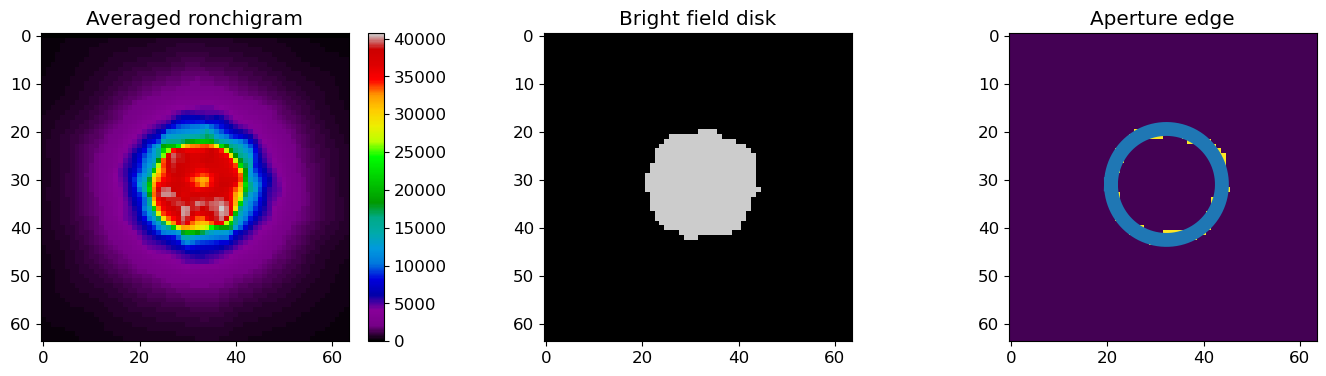

In [9]:
data_4D.center_ronchigrams()
data_4D.estimate_aperture_size()
data_4D.plot_aperture()

In [10]:
data_4D.truncate_ronchigram(expansion_ratio=None) # crops ronchigram to the BF disk
print(data_4D.data_4D_trunc.shape)
print(data_4D.wave_len)

(128, 128, 64, 64)
0.041757171951176904


Compute Fourier Transform with respect to the probe position

In [11]:
data_4D.apply_FT()
print(data_4D.data_4D_Reciprocal.shape)
print(data_4D.data_4D_Reciprocal.dtype)

(128, 128, 64, 64)
complex64


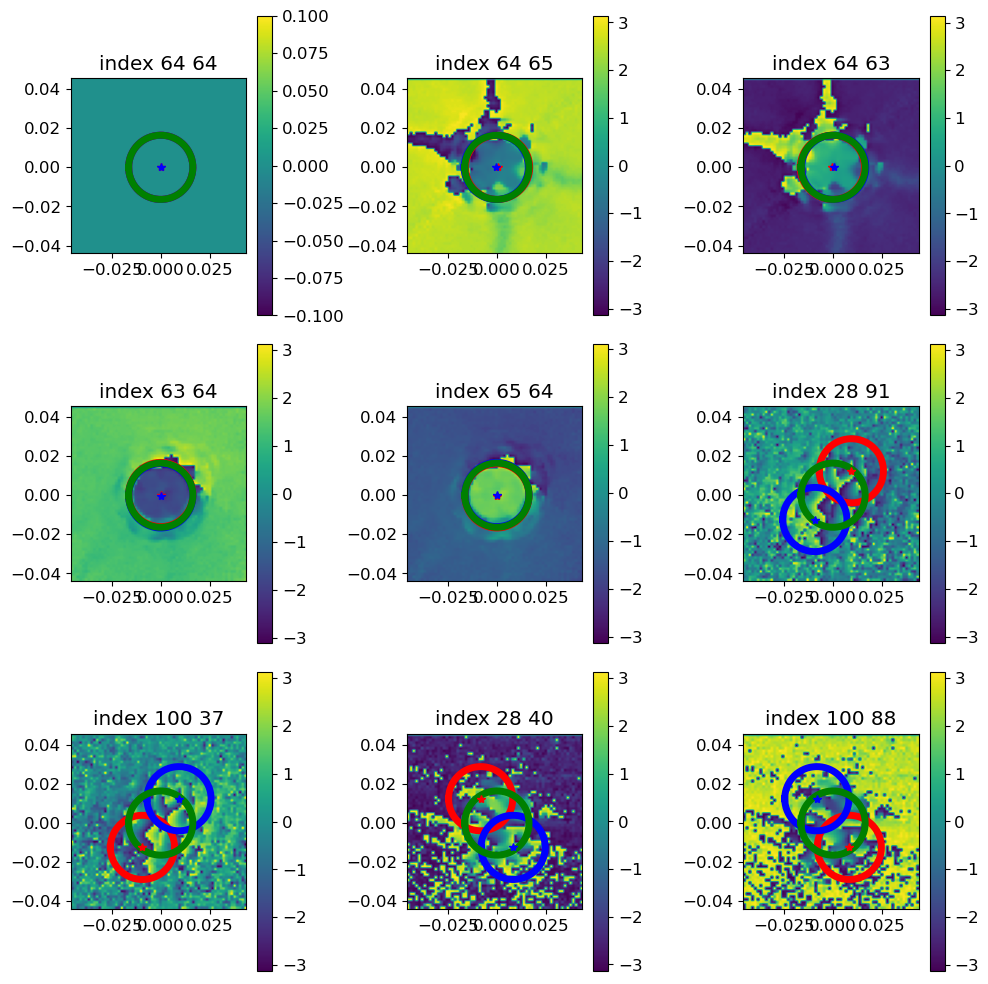

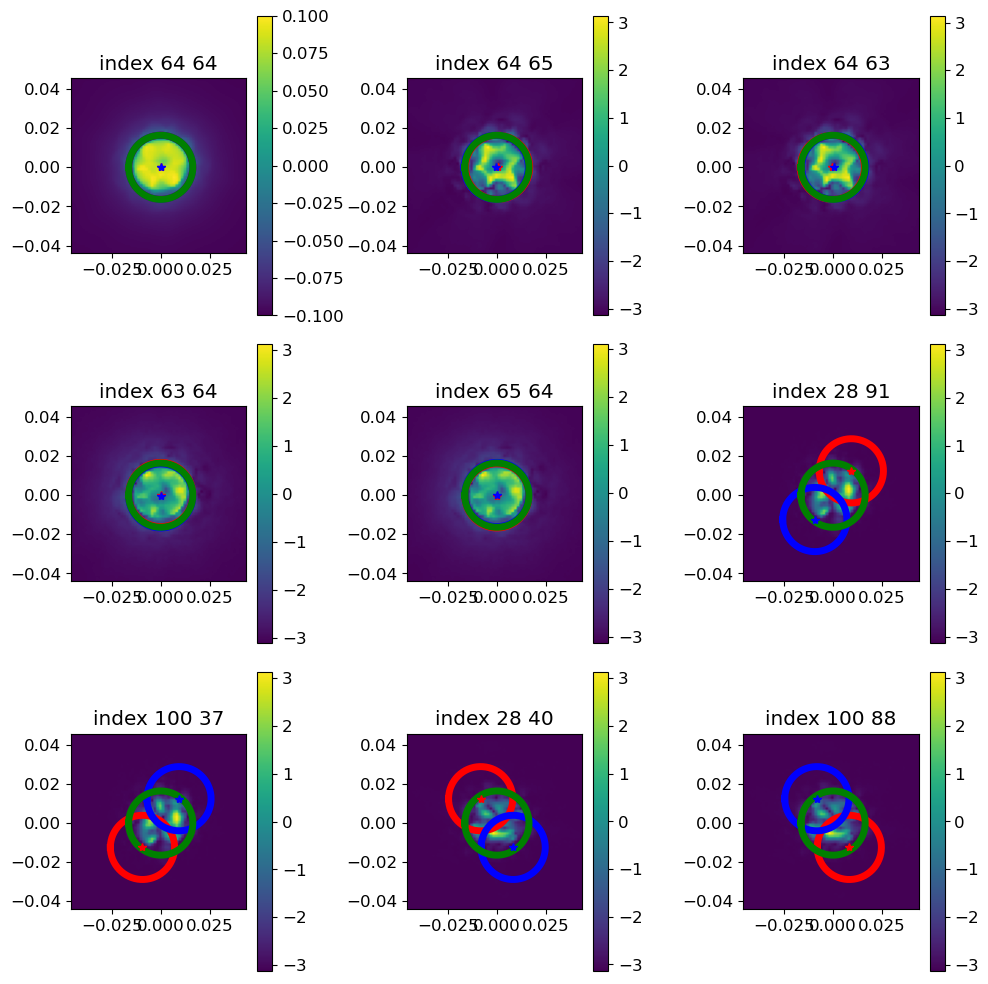

In [12]:
data_4D.plot_trotters(data_4D.rotation_angle_deg, plot_constrains=True, skip=0) # value that fits

selecting index 64  64
selecting index 65  64
selecting index 63  64
selecting index 64  63
selecting index 64  65
selecting index 91  28
selecting index 37  100
selecting index 40  28
selecting index 88  100
C10  =  -4.043  nm
C12a =  7.454  nm
C12b =  -1.793  nm
C21a =  -7.192  nm
C21b =  4.427  nm
C23a =  21.873  nm
C23b =  -18.034  nm
C30  =  -0.003  nm
C32a =  0.004  nm
C32b =  -0.002  nm
C34a =  0.0  nm
C34b =  0.0  nm


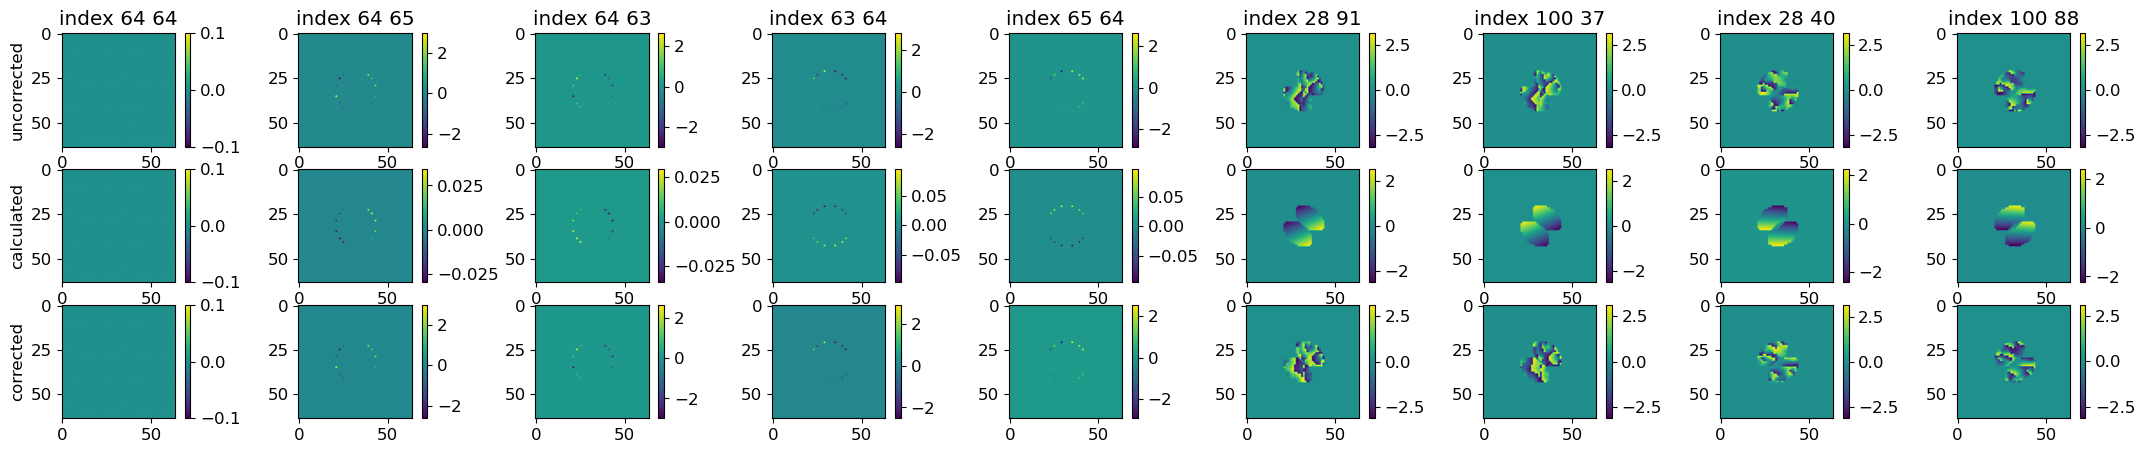

In [13]:
svd = SVD_AC(data_4D, trotters_nb=9)
svd.build_omnimatrix()
svd.run_SVD()
svd.print_aberration_coefficients()
svd.calc_aberrationfunction()
svd.calc_aperturefunction()
svd.calc_probefunction()
svd.plot_corrected_trotters(data_4D.selected_frames,-svd.aberration_coeffs)

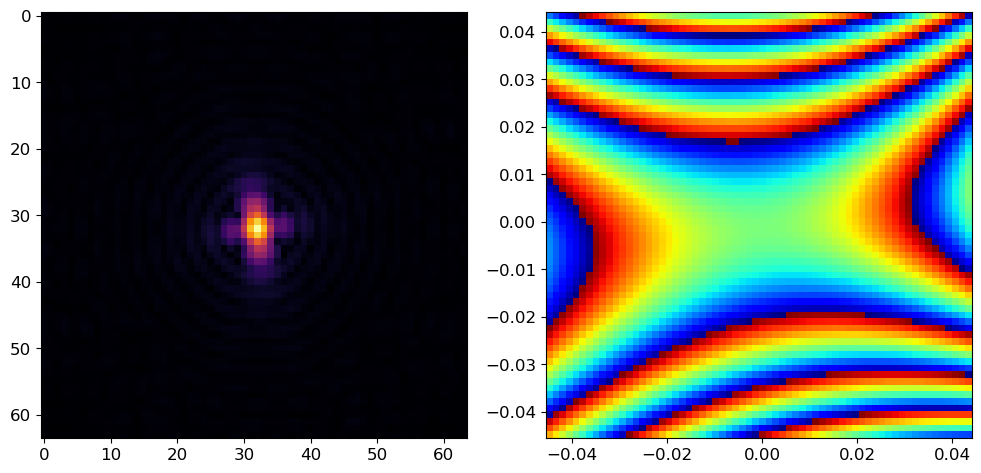

In [14]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].imshow(np.abs(svd.probe), cmap="inferno")
ax[1].imshow(np.angle(svd.func_transfer),extent=(svd.theta_x.min(),svd.theta_x.max(),svd.theta_y.min(),svd.theta_y.max()),cmap='jet')
fig.tight_layout()
plt.show()

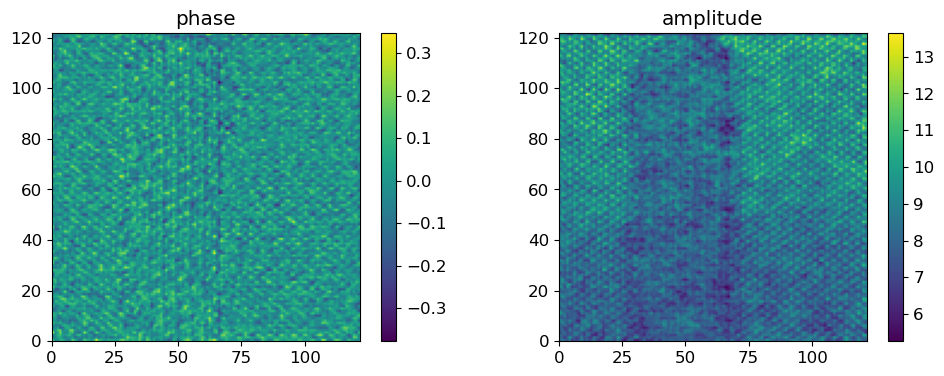

In [15]:
## without aberration correction

wdd_ac = WDD(data_4D)
wdd_ac.run(aberrations = -svd.aberration_coeffs)

wdd_ac.plot_result()

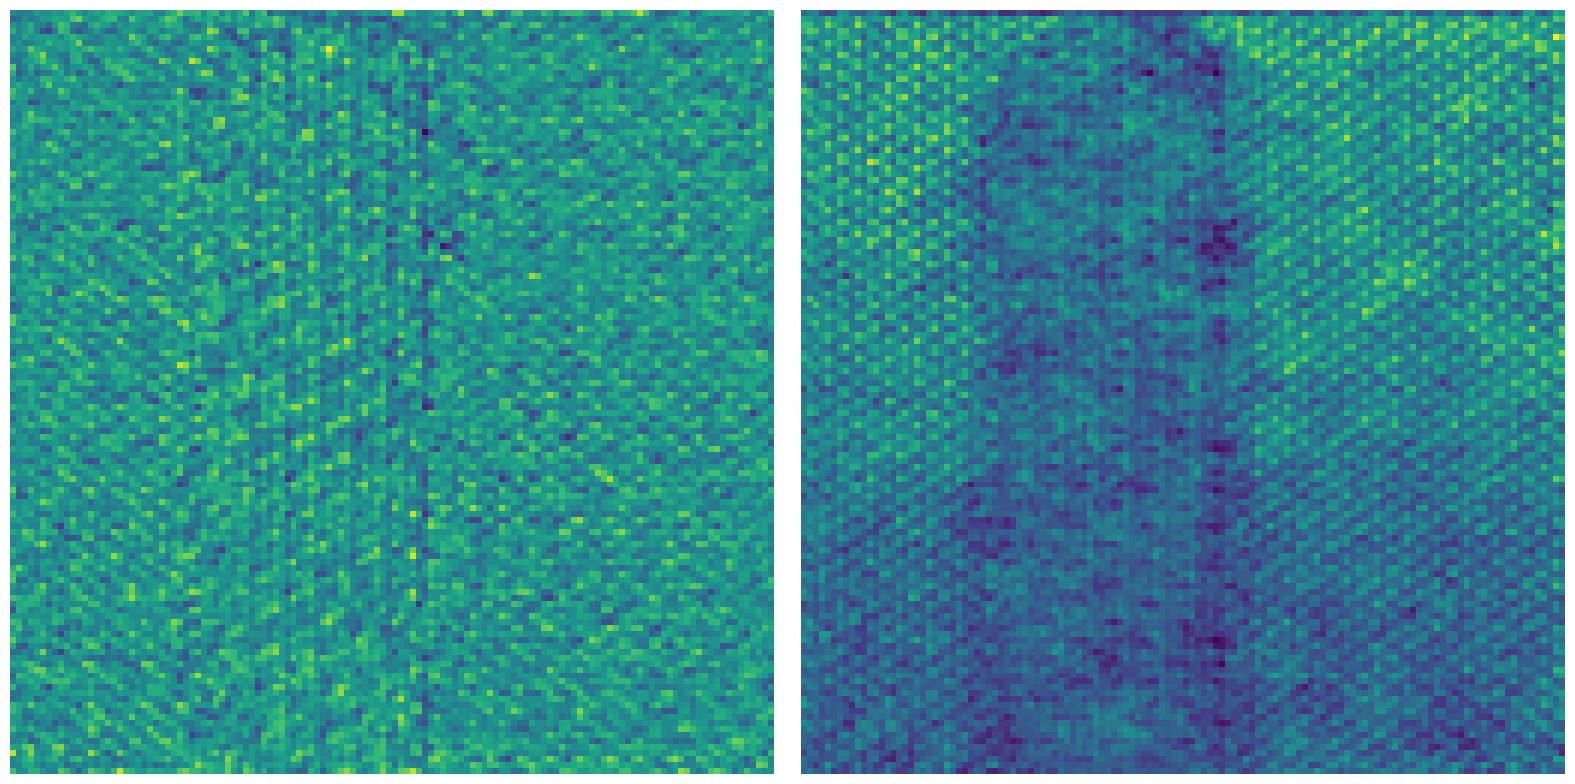

In [16]:
f,ax = plt.subplots(1, 2, figsize=(16, 8))
ax[0].imshow(wdd_ac.phase)
ax[1].imshow(wdd_ac.amplitude)
ax[0].axis("off")
ax[1].axis("off")
f.tight_layout()
plt.show()

In [ ]:
tifffile.imwrite("phase_wdd.tif", wdd_ac.phase)